# Exploratory data analysis & Tree building<a id='Exploratory_Data_Analysis'></a>

## Table of Contents
  * 1 [Import libriaries and Load data](#load_data)
  * 2 [Event data](#event_data)
    * 2.1 [Customer behavior](#customer_behavior)
      * 2.1.1 [Number of unique items purchased per customer](#items_per_customer)
      * 2.1.2 [Total number of purchase days per customer](#days_per_customer) 
    * 2.2 [Pre-basker analysis](#basket_analysis)
      * 2.2.1 [Number of unique items purchased per session](#items_per_session)
      * 2.2.2 [Fraction of transaction events per session](#transactions_per_session)
  * 3 [Tree building with category Data](#category_data)
    * 3.1 [Huffman binary tree](#huffman_tree)
      * 3.1.1 [Frequencies of items at leaf nodes](#frequency_item)
      * 3.1.2 [Prepare dictionary with format {category : {item ID : frequency}}](#build_dictionary)
      * 3.1.3 [Construct Huffman tree with items at leaf nodes](#build_huff_tree)
      * 3.1.4 [Visualize Huffman tree](#visualize_huff_tree)
    * 3.2 [Category tree](#category_tree)
      * 3.2.1 [Convert category DataFrame into hierarchical tree structure](#convert_df_to_tree)
      * 3.2.2 [Sanity check for linkage between items and categories](#sanity_check)
      * 3.2.3 [Add leaf (item) nodes to tree](#add_leaf_nodes)
      * 3.2.4 [Get full path to root](#get_full_path)

## 1 Import libraries and Load data<a id='load_data'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.decomposition import PCA
#from sklearn.preprocessing import scale
pd.options.mode.copy_on_write = True
from sb_utils import save_file
_debug_ = False

In [2]:
df_evt= pd.read_csv('events_df.csv')
df_cat= pd.read_csv('category_df.csv')

## 2 Events data<a id='event_data'></a>

In [3]:
df_evt.head()

,visitorid,event,itemid,transactionid,date,session_by_day,categoryid
0,0,view,285930,-1,2015-09-11,1,1188
1,0,view,357564,-1,2015-09-11,1,256
2,0,view,67045,-1,2015-09-11,1,333
3,1,view,72028,-1,2015-08-13,1,1192
4,2,view,342816,-1,2015-08-07,1,444


### 2.1 Customer behavior<a id='customer_behavior'></a>

#### 2.1.1 Number of unique items purchased per customer<a id='items_per_customer'></a>

Text(0.5, 1.0, 'Number of unique items purchased per customer')

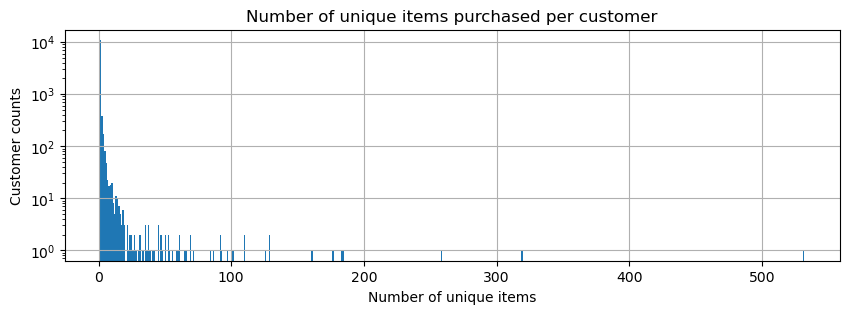

In [4]:
df_trs = df_evt[df_evt['event'] == 'transaction']

items_per_customer = df_trs.groupby('visitorid').agg(freq = pd.NamedAgg(column='itemid', aggfunc='nunique')).reset_index()
plt.figure(figsize=(10,3))
items_per_customer.freq.hist(bins=500)
plt.xlabel('Number of unique items')
plt.ylabel('Customer counts')
plt.yscale('log')
plt.title('Number of unique items purchased per customer')

In [5]:
# top buyer who purchased 532 items on 74 days between 2015-05-10 and 2015-09-13
items_per_customer[items_per_customer.freq>400]

,visitorid,freq
9541,1150086,532


In [6]:
df_trs[df_trs.visitorid==1150086].sort_values('date')

,visitorid,event,itemid,transactionid,date,session_by_day,categoryid
2258482,1150086,transaction,276704,4070,2015-06-11,1,1219
2262073,1150086,transaction,440066,15225,2015-06-11,1,646
2259398,1150086,transaction,375955,6495,2015-06-11,1,624
2262120,1150086,transaction,357133,5235,2015-06-11,1,637
2258643,1150086,transaction,310620,4070,2015-06-11,1,239
...,...,...,...,...,...,...,...
2261237,1150086,transaction,406727,17130,2015-09-16,73,725
2260107,1150086,transaction,340825,91,2015-09-16,73,34
2258611,1150086,transaction,99601,794,2015-09-16,73,1635
2260091,1150086,transaction,359910,8030,2015-09-16,73,227


#### 2.1.2 Total number of purchase days per customer<a id='days_per_customer'></a>

Text(0.5, 1.0, 'Total number of purchase days per customer')

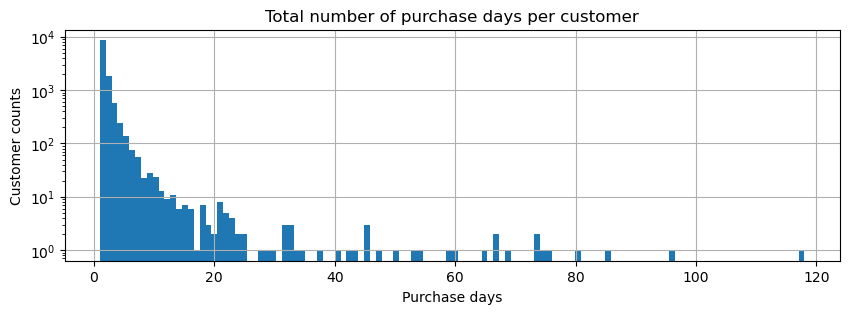

In [7]:

days_per_customer = df_trs.groupby('visitorid').agg(days = pd.NamedAgg(column='session_by_day', aggfunc='max')).reset_index()
plt.figure(figsize=(10,3))
days_per_customer.days.hist(bins=120)
plt.xlabel('Purchase days')
plt.ylabel('Customer counts')
plt.yscale('log')
plt.title('Total number of purchase days per customer')

### 2.2 Pre-basket analysis<a id='basket_analysis'></a>

Useful information for when training a model with data.

#### 2.2.1 Number of unique items purchased per session<a id='items_per_session'></a>

Text(0.5, 1.0, 'Number of unique items purchased per session')

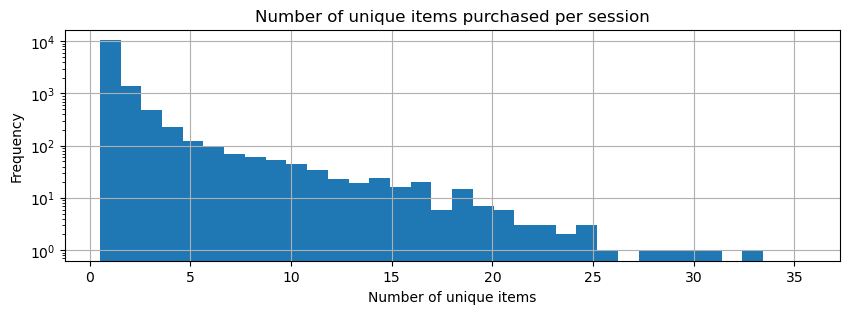

In [8]:
items_per_session = df_trs.groupby(['visitorid','session_by_day']).agg(freq = pd.NamedAgg(column='itemid', aggfunc='nunique')).reset_index()
plt.figure(figsize=(10,3))
items_per_session.freq.hist(bins=np.linspace(0.5,35.5,35))
plt.xlabel('Number of unique items')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Number of unique items purchased per session')

#### 2.2.2 Fraction of transaction events per session<a id='transactions_per_session'></a> 

In [9]:

def fraction(series):   
    return series[series > 0].count()/series.count()


transactions_per_session = df_evt.groupby(['visitorid','session_by_day'])\
.agg(frac=pd.NamedAgg(column='transactionid', aggfunc=fraction)).reset_index()


Text(0.5, 1.0, 'Fraction of transaction events per session ')

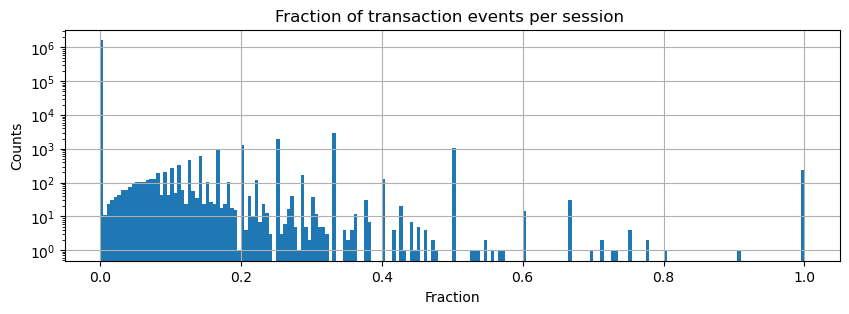

In [10]:
plt.figure(figsize=(10,3))
transactions_per_session.frac.hist(bins=200)
plt.xlabel('Fraction')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Fraction of transaction events per session ')

## 3 Tree building with category data<a id='category_data'></a>

#### There ere are two different types of trees we will be building:
  * Huffman binary tree for hierarchical softmax
  * Category tree for accessing category information associated with each item

### 3.1 Huffman binary tree<a id='huffman_tree'></a>

Huffman tree is a binary tree over items that is used for efficient probability estimation in hierarchical softmax training technique. It speeds up training and allows for scalable output layer.

In [11]:
from HuffmanTree import HuffmanNode,build_huffman_tree,generate_codebook,visualize_huffman_tree

#### 3.1.1 Frequencies of items at leaf nodes<a id='frequency_item'></a> 

Text(0.5, 1.0, 'Purchase frequency per item')

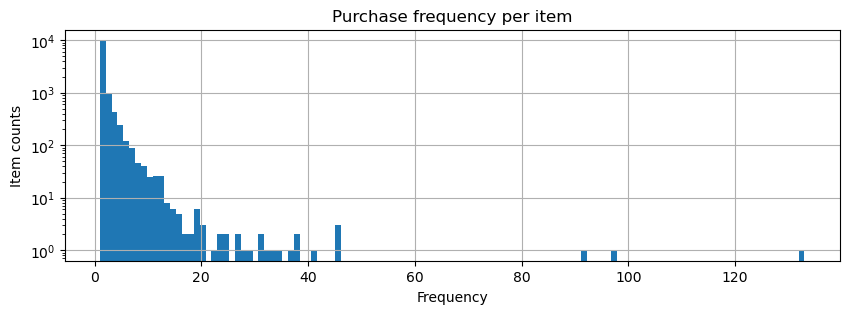

In [12]:

df_trs = df_evt[df_evt['event'] == 'transaction']
df_freq = df_trs.groupby('itemid').agg(frequency = pd.NamedAgg(column='itemid', aggfunc='size'),
                                      categoryid = pd.NamedAgg(column='categoryid',aggfunc= 'first')).reset_index()
plt.figure(figsize=[10,3])
df_freq.frequency.hist(bins=120)
plt.xlabel('Frequency')
plt.ylabel('Item counts')
plt.yscale('log')
plt.title('Purchase frequency per item')

#### 3.1.2 Prepare dictionary with format {category : {item ID : frequency}}<a id='build_dictionary'></a> 

This will be used to extend the tree to include categories directly associated with items.

In [13]:
df_freq.head()

,itemid,frequency,categoryid
0,15,1,722
1,19,1,1171
2,25,2,1509
3,42,1,84
4,147,4,646


In [14]:
dict_items = {}

for category, item in df_freq.groupby('categoryid'):
    if category <0:
        continue
    d = dict(zip(item['itemid'], item['frequency']))
    dict_items[category] = d
    
    if category == 0:
        print(f"Category: {category}")
        print(d)
    

Category: 0
{50722: 1, 101156: 2, 124055: 1, 132853: 1, 175322: 1, 220950: 1, 256952: 1, 261013: 1, 283492: 2, 289006: 1}


#### 3.1.3 Construct Huffman tree with items at leaf nodes<a id='build_huff_tree'></a>

In [15]:

begin_index = 500000
dict_combined = {}

for category, itemsdict in dict_items.items():
    dict_combined.update(itemsdict)

test = dict(list(dict_combined.items())[:5])
print(test) 
total_inner_nodes, tree = build_huffman_tree(begin_index, None, dict_combined, None)

print(f'Total number of inner nodes : {total_inner_nodes}')

{50722: 1, 101156: 2, 124055: 1, 132853: 1, 175322: 1}
Total number of inner nodes : 11644


#### 3.1.4 Visualize Huffman tree<a id='visualize_huff_tree'></a>

Total number of inner nodes (including root node) for category 0 : 9 


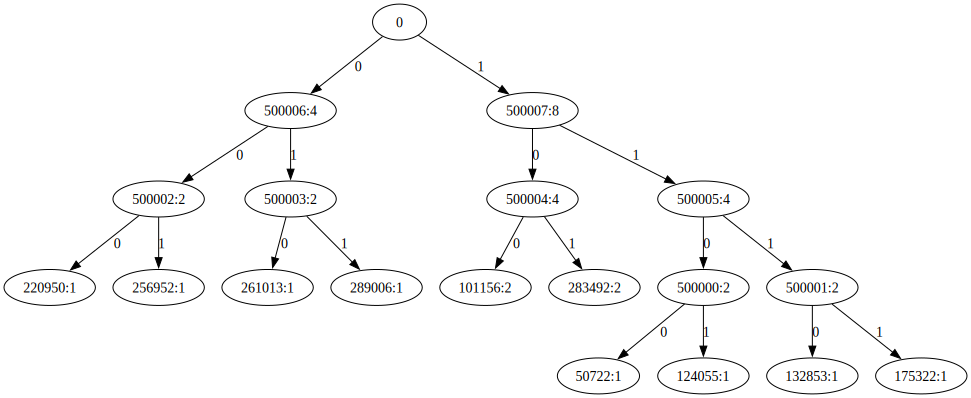

In [16]:
# For a test, visualize a small Huffman tree for category 0.
total_nodes, tree0 = build_huffman_tree(begin_index, root_index=0, item_counts=dict_items[0])
print(f'Total number of inner nodes (including root node) for category 0 : {total_nodes} ')
visualize_huffman_tree(tree0[0]) # [root_index]

### 3.2 Category tree<a id='category_tree'></a>

#### 3.2.1 Convert category DataFrame into hierarchical tree structure<a id='convert_df_to_tree'></a>

In [17]:
from CategoryTree import TreeNode, build_tree, add_to_node, get_path

In [18]:
# root node
tree_cat = TreeNode(10000) 

# build tree
build_tree(0,{10000:tree_cat}, df_cat)


In [19]:
# tests

if _debug_:
    print(tree_cat.members[1490].members.keys())
    print(tree_cat.members[1490].members[1525].parent.index)
    
_test_=True
if _test_:
    print(tree_cat.members[1490].members.keys())
    add_to_node(tree_cat,1490,1111)
    print(tree_cat.members[1490].members.keys())

    path = []
    p = get_path(tree_cat, 1525,path)
    print(path)    

dict_keys([1444, 1525, 1332, 207, 25, 1497, 788, 145, 798, 664])
dict_keys([1444, 1525, 1332, 207, 25, 1497, 788, 145, 798, 664, 1111])
[1525, 1490, 10000]


#### 3.2.2 Sanity check for linkage between items and categories<a id='sanity_check'></a>

See if all categories linked to items are terminal nodes in the category tree.

In [20]:
### Lowest level categories from category tree

positive_counts = (df_cat >= 0).sum(axis=1)
term_levels = ['L'+ str(i-1) for i in positive_counts]

terminals = [ df_cat.loc[i:i][level].tolist() for i, level in enumerate(term_levels) ]
terminals = np.array(sorted(terminals))
set_term = set(terminals.flatten())

### Terminal-level categories from items
set_items = set(dict_items.keys())

In [21]:
# non-terminal catetories associated with items

non_terminal = list(set_items - set_term)
non_terminal

[640,
 131,
 520,
 1292,
 781,
 20,
 799,
 47,
 48,
 1079,
 568,
 959,
 1215,
 586,
 1228,
 1486,
 209,
 340,
 1374,
 479,
 95,
 1120,
 229,
 746,
 747]

Upon inspection, some items are linked to non-terminal categories. \
We will attach all items to the appropriate nodes in the category tree. 

#df_cat[df_cat.L3.isin( [47,48,95,131,209,479,  229,340,520 ] )]

#### 3.2.3 Add leaf nodes to tree<a id='add_leaf_nodes'></a>

In [22]:

for catid, itemid in dict_items.items():
    for itemidx in itemid.keys():
        add_to_node(tree_cat,catid,itemidx) 


#### 3.2.4 Get full path to root<a id='get_full_path'></a>

In [23]:
# test with item iD 132853

path = []
get_path(tree_cat,132853, path)
print('item ID <------> root')
print(path)

item ID <------> root
[132853, 0, 605, 1482, 10000]


These will be utilized for training data. 